In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import gym
import random

env = gym.make('LunarLanderContinuous-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode:  0 , Average reward:  -118.25957136788253
Episode:  1 , Average reward:  -141.63435673371777
Episode:  2 , Average reward:  -175.98162984533246
Episode:  3 , Average reward:  -207.79235208394363
Episode:  4 , Average reward:  -215.9963437640321
Episode:  5 , Average reward:  -197.5705355575744
Episode:  6 , Average reward:  -178.39503599711796
Episode:  7 , Average reward:  -172.81826513887387
Episode:  8 , Average reward:  -164.9924190819399
Episode:  9 , Average reward:  -167.34458861892378
Episode:  10 , Average reward:  -165.70025700339582
Episode:  11 , Average reward:  -195.12857013984126
Episode:  12 , Average reward:  -218.03937614329328
Episode:  13 , Average reward:  -242.8521044016047
Episode:  14 , Average reward:  -256.86536783953255
Episode:  15 , Average reward:  -271.07642029379065
Episode:  16 , Average reward:  -300.38275167479253
Episode:  17 , Average reward:  -314.25136546003785
Episode:  18 , Average reward:  -335.2632785216426
Episode:  19 , Average rewa

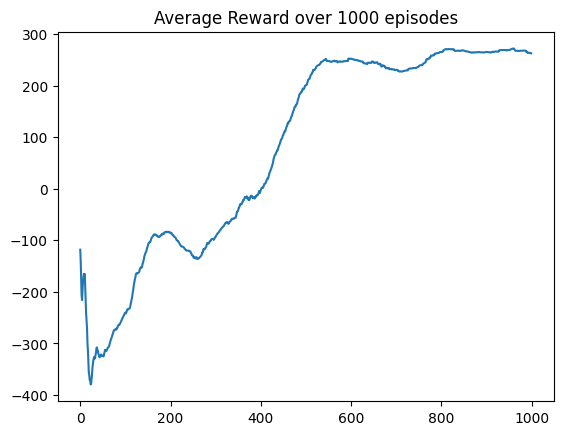

In [ ]:
class Buffer():

    def __init__(self, batch_size):

        self.storage = deque(maxlen=100000)
        self.batch_size = batch_size

    def experience_replay(self):
     
        batch_size = min(self.batch_size, len(self.storage))
        arrs = random.sample(self.storage, batch_size)
        
        states, actions, rewards,further,dones =  map(list,zip(*arrs))
        
        states = tf.convert_to_tensor(np.array(states), dtype = tf.float32)
        actions = tf.convert_to_tensor(np.array(actions), dtype = tf.float32)
        rewards = tf.convert_to_tensor(np.array(rewards), dtype = tf.float32)
        further = tf.convert_to_tensor(np.array(further), dtype = tf.float32)
        dones = tf.convert_to_tensor(np.array(dones), dtype = tf.float32)
        
        return states, actions, rewards,further,dones

    def remember(self, state, action, reward, next_state,done): 

        self.storage.append((state, action, reward, next_state,done))

class TD3():
    def __init__(self, input_dims, tau, env, layer1, layer2, batch_size, gamma, noise, output_actions, plays = 1000, max_size = 1000000):
      
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.update = 2
        self.batch_size = batch_size
        self.memory = Buffer(self.batch_size)
        self.noise = noise
        self.step = 0
        self.time_step = 0
        self.plays= plays
        self.output_actions = output_actions
        
        self.actor = Actor(layer1, layer2,output_actions)
        self.actor_target = Actor(layer1, layer2, output_actions)
        self.actor.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean')
        self.actor_target.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean')
        
        self.critic = Critic(layer1, layer2, output_actions)
        self.critic_target = Critic(layer1, layer2, output_actions)
        self.critic.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')
        self.critic_target.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')

    def store_experiences(self, state, action, reward, new_state, done):
        self.memory.remember(state, action, reward, new_state, done)

    def mean(self, weigh, target):
         
        average = weigh * self.tau + target*(1-self.tau)
        return average
    
    def compute_updated(self, network, network_target):
        
        new_weights = []
        targets = network_target.weights
        weights = network.weights
       
        for i in range(len(weights)):
        
            new_weights.append(self.mean(weights[i],targets[i]))
    
        return new_weights

    def act_decide(self, state):
        
        if self.time_step > self.plays:
            
            state = tf.convert_to_tensor([state], dtype=tf.float32)
            pi = self.actor(state)[0]
            
        else:
            pi = self.calc_signal(self.noise, size=(self.output_actions,))
            
        pi_prime = pi + self.calc_signal(self.noise, size = None)

        pi_prime = tf.clip_by_value(pi_prime, self.min_action, self.max_action)
        self.time_step += 1

        return pi_prime
    
    def new_net(self, network, network_target):

        new_weights = self.compute_updated(network, network_target)
        network_target.set_weights(new_weights)

    def learn(self):
        if len(self.memory.storage) > self.batch_size:
            states, actions, rewards, further, dones = self.memory.experience_replay()

            with tf.GradientTape(persistent=True) as grad:
                actions_target = self.actor_target(further)
                actions_target = actions_target + tf.clip_by_value(self.calc_signal(0.2, size = None), -0.5,0.5)
                actions_target = tf.clip_by_value(actions_target, self.min_action, self.max_action)

                Q1, Q2 = self.critic(states, actions)
                Q1_target, Q2_target = self.critic_target(further, actions_target)

                Q1, Q2 = tf.squeeze(Q1, axis = 1), tf.squeeze(Q2, axis = 1)
                Q1_target, Q2_target = tf.squeeze(Q1_target, 1), tf.squeeze(Q2_target, 1)

                critic_value = tf.minimum(Q1_target, Q2_target)
                target = rewards + self.gamma*critic_value*(1-dones)

                critic_loss =  MSE(target, Q1) + MSE(target, Q2)

            new_grad = grad.gradient(critic_loss, self.critic.trainable_variables)
           
            self.critic.optimizer.apply_gradients(zip(new_grad, self.critic.trainable_variables))
            self.step += 1

            if self.step% self.update == 0:
            
                with tf.GradientTape() as grad:
                    next_actions = self.actor(states)
                    Q1_value, Q2_value = self.critic(states, next_actions)
                    act_lost = -tf.reduce_mean(Q1_value)

                actor_grad = grad.gradient(act_lost, self.actor.trainable_variables)
                self.actor.optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))
                    
                
                self.new_net(self.actor, self.actor_target)
                self.new_net(self.critic, self.critic_target)

    def calc_signal(self, noise, size):
        
        return np.random.normal(scale = noise, size = size)

class Actor(keras.Model):
    
    def __init__(self, layer1, layer2, output_actions):
        super(Actor, self).__init__()
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.output_actions = output_actions
        self.Dense1 = keras.layers.Dense(self.layer1, activation = 'LeakyReLU')
        self.Dense2 = keras.layers.Dense(self.layer2, activation = 'LeakyReLU')
        self.out_a = keras.layers.Dense(self.output_actions, activation = 'softmax')

    def call(self, state):
        act = self.Dense1(state)
        act = self.Dense2(act)
        out_act = self.out_a(act)

        return out_act

class Critic(keras.Model):
    def __init__(self,layer1, layer2, output_actions):
        super(Critic, self).__init__()
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.output_actions = output_actions
        self.Dense1 = keras.layers.Dense(self.layer1, activation = 'LeakyReLU')
        self.Dense2 = keras.layers.Dense(self.layer2, activation = 'LeakyReLU')
        self.first = keras.layers.Dense(1, activation = 'softmax')
        
        self.Dense3 = keras.layers.Dense(self.layer1, activation = 'LeakyReLU')
        self.Dense4 = keras.layers.Dense(self.layer2, activation = 'LeakyReLU')
        self.second = keras.layers.Dense(1, activation = 'softmax')
  
    def call(self, state, action):

        crit1 = self.Dense1(tf.concat([state, action], axis=1))
        crit1 = self.Dense2(crit1)
        first_layer = self.first(crit1)
        
        crit2 = self.Dense3(tf.concat([state, action], axis=1))
        crit2 = self.Dense4(crit2)
        second_layer = self.second(crit2)

        return first_layer, second_layer

obj = TD3(input_dims = env.observation_space.shape, tau = 0.005, env = env, batch_size = 100, layer1 = 400, layer2 = 300, output_actions = env.action_space.shape[0], gamma = 0.99, noise = 0.1)

prev = []
avg_reward_list = []

for episode in range(2):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = obj.act_decide(state)
        state_, reward, done, info = env.step(action)
        obj.store_experiences(state, action, reward, state_, done)
        obj.learn()
        score += reward
        state = state_

    prev.append(score)
    avg_reward = np.mean(prev[-100:])
    avg_reward_list.append(avg_reward)

    print('Episode: ', episode, ', Average reward: ', avg_reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
